# Optimización Geometalúrgica inspirado en Distrito Mantoverde (IOCG)
**Autor:** Pablo Toledo
**Fecha:** 01/12/2025

---

### **1. El Por Qué**
En la minería moderna, la incertidumbre geológica es costosa. Este miniproyecto aborda dos problemas críticos en depósitos IOCG como Mantoverde:
1.  **Molienda (Sulfuros):** La dureza variable (Magnetita vs. Especularita) impacta el rendimiento del Molino SAG.
2.  **Lixiviación (Óxidos):** La presencia oculta de carbonatos dispara el consumo de ácido sulfúrico.

El objetivo de este notebook es mostrar mediante simulacion (no tengo datos reales) como se pueden transformar datos geológicos en decisiones operativas antes de que el mineral llegue a la planta.

### **2. El Cómo**
Se desarrolló un modelo de Machine Learning (XGBoost) entrenado sobre una base de datos sintética, calibrada con parámetros del reporte técnico NI 43-101 de Mantoverde (2024) y literatura sobre IOCGs australianos.

**Flujo de Trabajo:**
* **Geología Vectorial:** Simulación de zonificación mineral (Núcleo de Magnetita-K) y control estructural (Falla Mantoverde).
* **Geoquímica:** Cálculo de Mineralogía Normativa a partir de leyes de laboratorio (Fe, S, Cu) para cuantificar la magnetita real.
* **Aprendizaje automático:** Entrenamiento de un modelo predictivo auditado con SHAP (explicabilidad del modelo a partir de x variables) para garantizar que las predicciones obedezcan a principios físicos válidos.

### **3. El Resultado**
La herramienta final simula un **Plan Semanal de Producción**, entregando:
1.  **Predicción de Dureza (BWi):** Para ajustar la velocidad del molino.
2.  **Alerta de Consumo Ácido:** Para evitar procesar bloques con alto carbonato.
3.  **Evaluación Económica:** Clasificación automática de bloques (Mineral vs. Lastre) basada en margen ($/ton), considerando costos.

---
**Referencias Principales:**
* Capstone Copper (2024). Mantoverde Mine NI 43-101 Technical Report.
* Cloutier, J. et al. (2025). IOCG potential using hybrid data approaches. Ore Geology Reviews.
*  Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.


In [2]:
##_0_LIBRERÍAS Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Estilo profesional para gráficos
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliotecas cargadas correctamente.")

Bibliotecas cargadas correctamente.


In [3]:
##_1_GENERACIÓN DE DATOS (LÓGICA SIMULADA: BUZAMIENTO 50° ESTE)

def generar_dataset_iocg(n_samples=3000):
    np.random.seed(99)

    # Espacio
    east = np.random.uniform(350000, 352500, n_samples)
    north = np.random.uniform(7050000, 7054000, n_samples)
    # Cota superficie ~900m, fondo ~400m
    elev = np.random.uniform(400, 900, n_samples)

    def get_spatial_noise(e, n, z, scale=1000):
        return np.sin(e/scale) * np.cos(n/scale) + np.sin(z/(scale/2)) * 0.5

    # ESTRUCTURAL (BUZAMIENTO)
    # La Falla Mantoverde buza ~50° al Este.
    # Esto significa que a mayor profundidad, la falla se mueve al Este.
    # Tan(50°) ~= 1.2
    # Desplazamiento = (Cota_Ref - Elev) / Tan(Dip)

    dip_angle = 50 #Grados
    tan_dip = np.tan(np.radians(dip_angle))

    # Eje de la falla en superficie (Cota 900)
    falla_surf = 351000 + 100 * np.sin(north / 800)

    # Eje de la falla a la profundidad Z (Proyección del plano)
    # Si buza al Este (+East), el eje aumenta con la profundidad?
    # No, si buza al este, la falla "se aleja" hacia el este al bajar.
    # Corrección: El plano inclinado define la distancia 0.

    # Calculamos la posición X de la falla para cada cota Z
    falla_x_at_z = falla_surf + (900 - elev) / tan_dip

    # Distancia perpendicular (aprox) a la falla inclinada
    # (Usamos distancia horizontal al plano para simplificar zonación)
    dist_falla_inclinada = east - falla_x_at_z

    # DOMINIOS GEOLÓGICOS (ASIMÉTRICOS)
    # La mineralización está principalmente en el Hanging Wall (Lado Este, dist > 0)
    # Pero hay algo en el Footwall (Lado Oeste, dist < 0).

    litos, alteracion, zona_min = [], [], []
    fe_pct, k_pct, s_pct, densidad, silice, rqd = [], [], [], [], [], []
    cut_pct, cus_pct, caco3_pct, co_ppm, magsus = [], [], [], [], []
    bwi = np.zeros(n_samples)

    for i in range(n_samples):
        local_var = get_spatial_noise(east[i], north[i], elev[i], scale=200)

        # Distancia absoluta al plano de falla (para zonación concéntrica)
        d_abs = abs(dist_falla_inclinada[i])
        # Sesgo hacia el este (Hanging Wall es más rico)
        is_hanging_wall = dist_falla_inclinada[i] > 0

        # 1. Alteración
        lim_pot = 150 + (local_var * 60)
        lim_trans = 400 + (local_var * 50)

        val_caco3 = np.random.exponential(1.5)

        if d_abs < lim_pot:
            alt = 'Magnetita_K'
            val_fe, val_k, val_sg, val_co = 50, 4.5, 4.4, 80
            val_mag = 8500
        elif d_abs < lim_trans:
            alt = 'Hematita_Silice'
            val_fe, val_k, val_sg, val_co = 30, 1.5, 3.6, 300
            val_mag = 400
        else:
            alt = 'Clorita_Calcita'
            val_fe, val_k, val_sg, val_co = 8, 1.0, 2.75, 40
            val_mag = 100
            val_caco3 += 8.0

        alteracion.append(alt)

        # Litología (Controlada por la falla inclinada)
        lim_brecha = 120 + (np.cos(elev[i]/100) * 20)

        # Asimetría: Las brechas se extienden más en el bloque colgante (HW)
        if is_hanging_wall: lim_brecha += 100

        if d_abs < lim_brecha:
            if alt == 'Magnetita_K': litos.append('Brecha_Magnetita')
            else: litos.append('Brecha_Especularita')
        else:
            litos.append('Andesita_LaNegra')

        # Zona Mineral (Reporte: Mixtos 15-45m espesor)
        nivel_ox = 750 + (local_var * 30) # Ondulación suave
        espesor_mixtos = 40               # Según reporte

        val_cut = np.random.lognormal(np.log(0.6), 0.4)

        if elev[i] > nivel_ox:
            zona_min.append('Oxidos')
            val_s = 0.1
            ratio_sol = np.random.uniform(0.70, 0.95)
        elif elev[i] > (nivel_ox - espesor_mixtos):
            zona_min.append('Mixtos')
            val_s = 1.5
            ratio_sol = np.random.uniform(0.30, 0.70)
        else:
            zona_min.append('Sulfuros')
            val_s = 3.5
            ratio_sol = np.random.uniform(0.05, 0.15)

        val_cus = val_cut * ratio_sol

        # VARIABLES FÍSICAS
        # Silicificación
        sil_val = 5 + (np.sin(east[i]/150)*4) + np.random.normal(0, 2)

        # RQD: Falla inclinada daña la roca en su plano
        r_val = 100 - (2000 / (d_abs + 10)) + (local_var * 10)

        # Guardar
        fe_pct.append(np.clip(val_fe + np.random.normal(0,4), 1, 70))
        k_pct.append(np.clip(val_k + np.random.normal(0,0.8), 0.1, 8))
        s_pct.append(np.clip(val_s + np.random.normal(0,0.5), 0.01, 10))
        densidad.append(np.clip(val_sg + np.random.normal(0,0.2), 2.4, 5.5))
        silice.append(np.clip(sil_val, 0, 30))
        rqd.append(np.clip(r_val + np.random.normal(0,15), 0, 100))

        cut_pct.append(np.clip(val_cut, 0.01, 5.0))
        cus_pct.append(np.clip(val_cus, 0.01, 5.0))
        caco3_pct.append(np.clip(val_caco3 + np.random.normal(0, 1.5), 0, 40))
        co_ppm.append(np.clip(val_co + np.random.normal(0, 100), 10, 1000))
        magsus.append(np.clip(val_mag + np.random.normal(0, 500), 0, 15000))

        # METALURGIA
        base = 12.0
        if densidad[-1] > 3.8: base += 5.0
        if silice[-1] > 10: base += 3.0
        if rqd[-1] < 40: base -= 2.5
        if caco3_pct[-1] > 5: base -= 2.0
        if zona_min[-1] == 'Oxidos': base *= 0.85

        bwi[i] = base + np.random.normal(0, 0.4)

    return pd.DataFrame({
        'East':east, 'North':north, 'Elev':elev,
        'Litologia':litos, 'Alteracion':alteracion, 'Zona':zona_min,
        'Fe':fe_pct, 'K':k_pct, 'S':s_pct, 'Densidad':densidad, 'Silice':silice, 'RQD':rqd,
        'CuT':cut_pct, 'CuS':cus_pct, 'CaCO3':caco3_pct, 'Co_ppm':co_ppm, 'MagSus':magsus,
        'BWi':bwi
    })

df = generar_dataset_iocg()
print(f"1. Dataset 'Mantoverde Realista' Generado: {df.shape} muestras.")

1. Dataset 'Mantoverde Realista' Generado: (3000, 18) muestras.


Calculando Mineralogía Normativa (Magnetita Calculada)...
   -> Variable 'Magnetita_Calc' agregada al dataset.


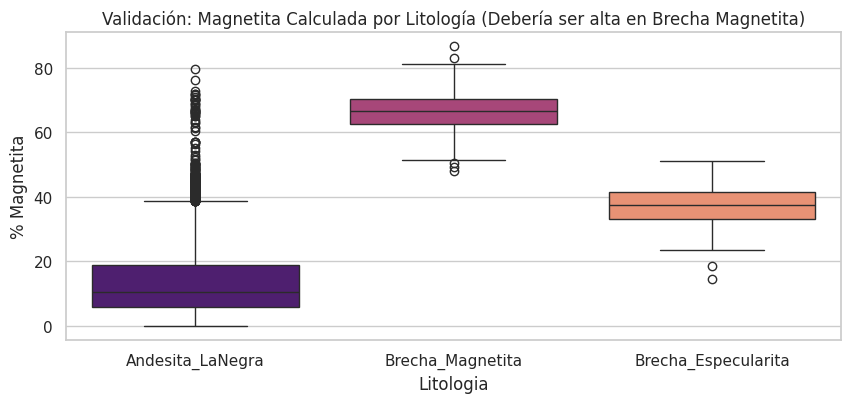

In [4]:
##_2_CÁLCULO DE MINERALOGÍA NORMATIVA
# Obj: Transformar leyes químicas (Fe, S) en mineralogía física (Magnetita)
# para mejorar la predicción de dureza.

print("Calculando Mineralogía Normativa (Magnetita Calculada)...")

def calcular_mineralogia(data):
    df_calc = data.copy()

    # Cálculo de Hierro en Sulfuros
    # Asumimos que el S está principalmente en Pirita/Calcopirita (FeS2 / CuFeS2)
    # Factor estequiométrico promedio S -> Fe_Sulfuro ~= 0.87
    df_calc['Fe_in_Sulphides'] = df_calc['S'] * 0.87

    # Cálculo de Hierro en Óxidos (Magnetita/Hematita)
    # El hierro total menos el hierro de sulfuros es el hierro "duro"
    df_calc['Fe_Oxido'] = df_calc['Fe'] - df_calc['Fe_in_Sulphides']
    df_calc['Fe_Oxido'] = df_calc['Fe_Oxido'].clip(lower=0) # Evitar negativos

    # Magnetita Calculada (Fe3O4)
    # Factor Fe -> Magnetita ~= 1.38 (72.4% Fe en Magnetita pura)
    df_calc['Magnetita_Calc'] = df_calc['Fe_Oxido'] * 1.38

    return df_calc

# Aplicamos la transformación
df = calcular_mineralogia(df)

print("   -> Variable 'Magnetita_Calc' agregada al dataset.")

# Validación Visual
plt.figure(figsize=(10, 4))
sns.boxplot(x='Litologia', y='Magnetita_Calc', data=df, palette='magma')
plt.title('Validación: Magnetita Calculada por Litología (Debería ser alta en Brecha Magnetita)')
plt.ylabel('% Magnetita')
plt.show()

Visualizando PROXYS


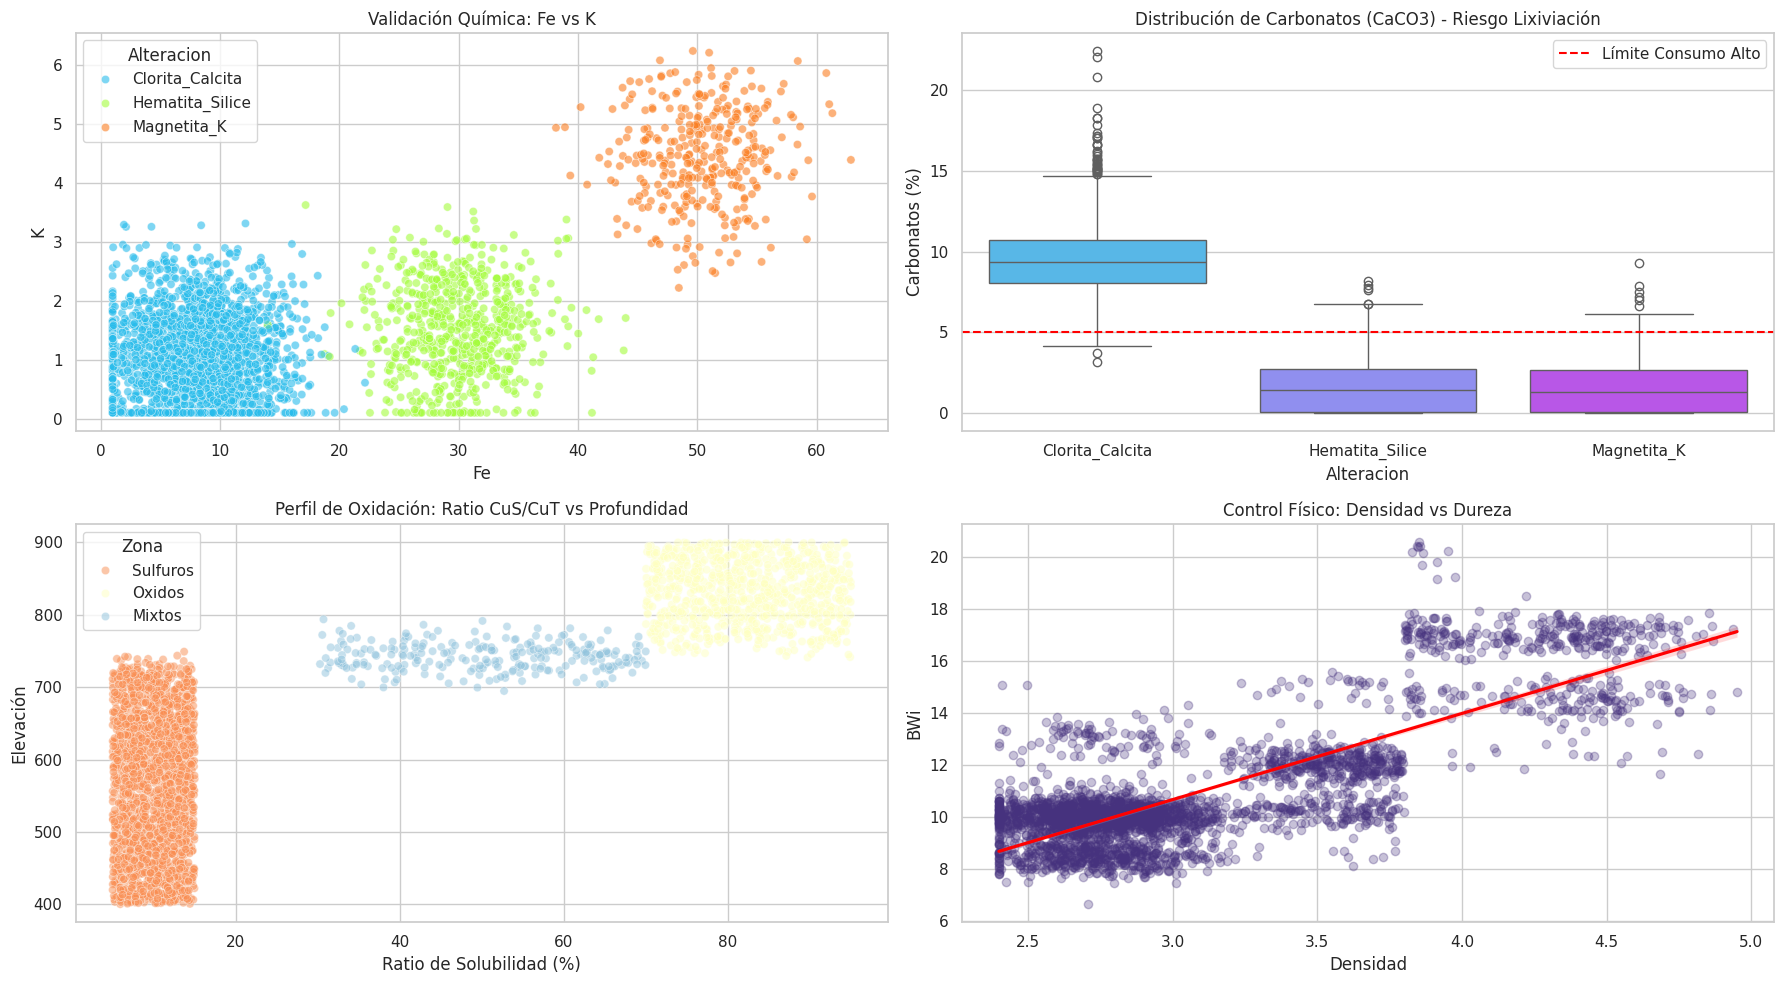

In [5]:
##_3_GEOQUÍMICA
print("Visualizando PROXYS")

fig, ax = plt.subplots(2, 2, figsize=(18, 10))

# Fe vs K (Discriminante Alteración)
sns.scatterplot(x='Fe', y='K', hue='Alteracion', data=df, ax=ax[0,0], palette='turbo', alpha=0.6)
ax[0,0].set_title('Validación Química: Fe vs K')

# Calcita vs Alteración (Riesgo de Consumo de Ácido)
sns.boxplot(x='Alteracion', y='CaCO3', data=df, ax=ax[0,1], palette='cool')
ax[0,1].set_title('Distribución de Carbonatos (CaCO3) - Riesgo Lixiviación')
ax[0,1].set_ylabel('Carbonatos (%)')
ax[0,1].axhline(5, color='red', linestyle='--', label='Límite Consumo Alto')
ax[0,1].legend()

# Ratio de Solubilidad con Profundidad (Perfil de Oxidación)
df['Ratio_Sol'] = (df['CuS'] / df['CuT']) * 100
sns.scatterplot(x='Ratio_Sol', y='Elev', hue='Zona', data=df, ax=ax[1,0], palette='RdYlBu', alpha=0.5)
ax[1,0].set_title('Perfil de Oxidación: Ratio CuS/CuT vs Profundidad')
ax[1,0].set_xlabel('Ratio de Solubilidad (%)')
ax[1,0].set_ylabel('Elevación')

# Densidad vs BWi (Física de Rocas)
sns.regplot(x='Densidad', y='BWi', data=df, ax=ax[1,1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
ax[1,1].set_title('Control Físico: Densidad vs Dureza')

plt.tight_layout()
plt.show()

Generando Panel de Validación Geológica (4 Vistas)...


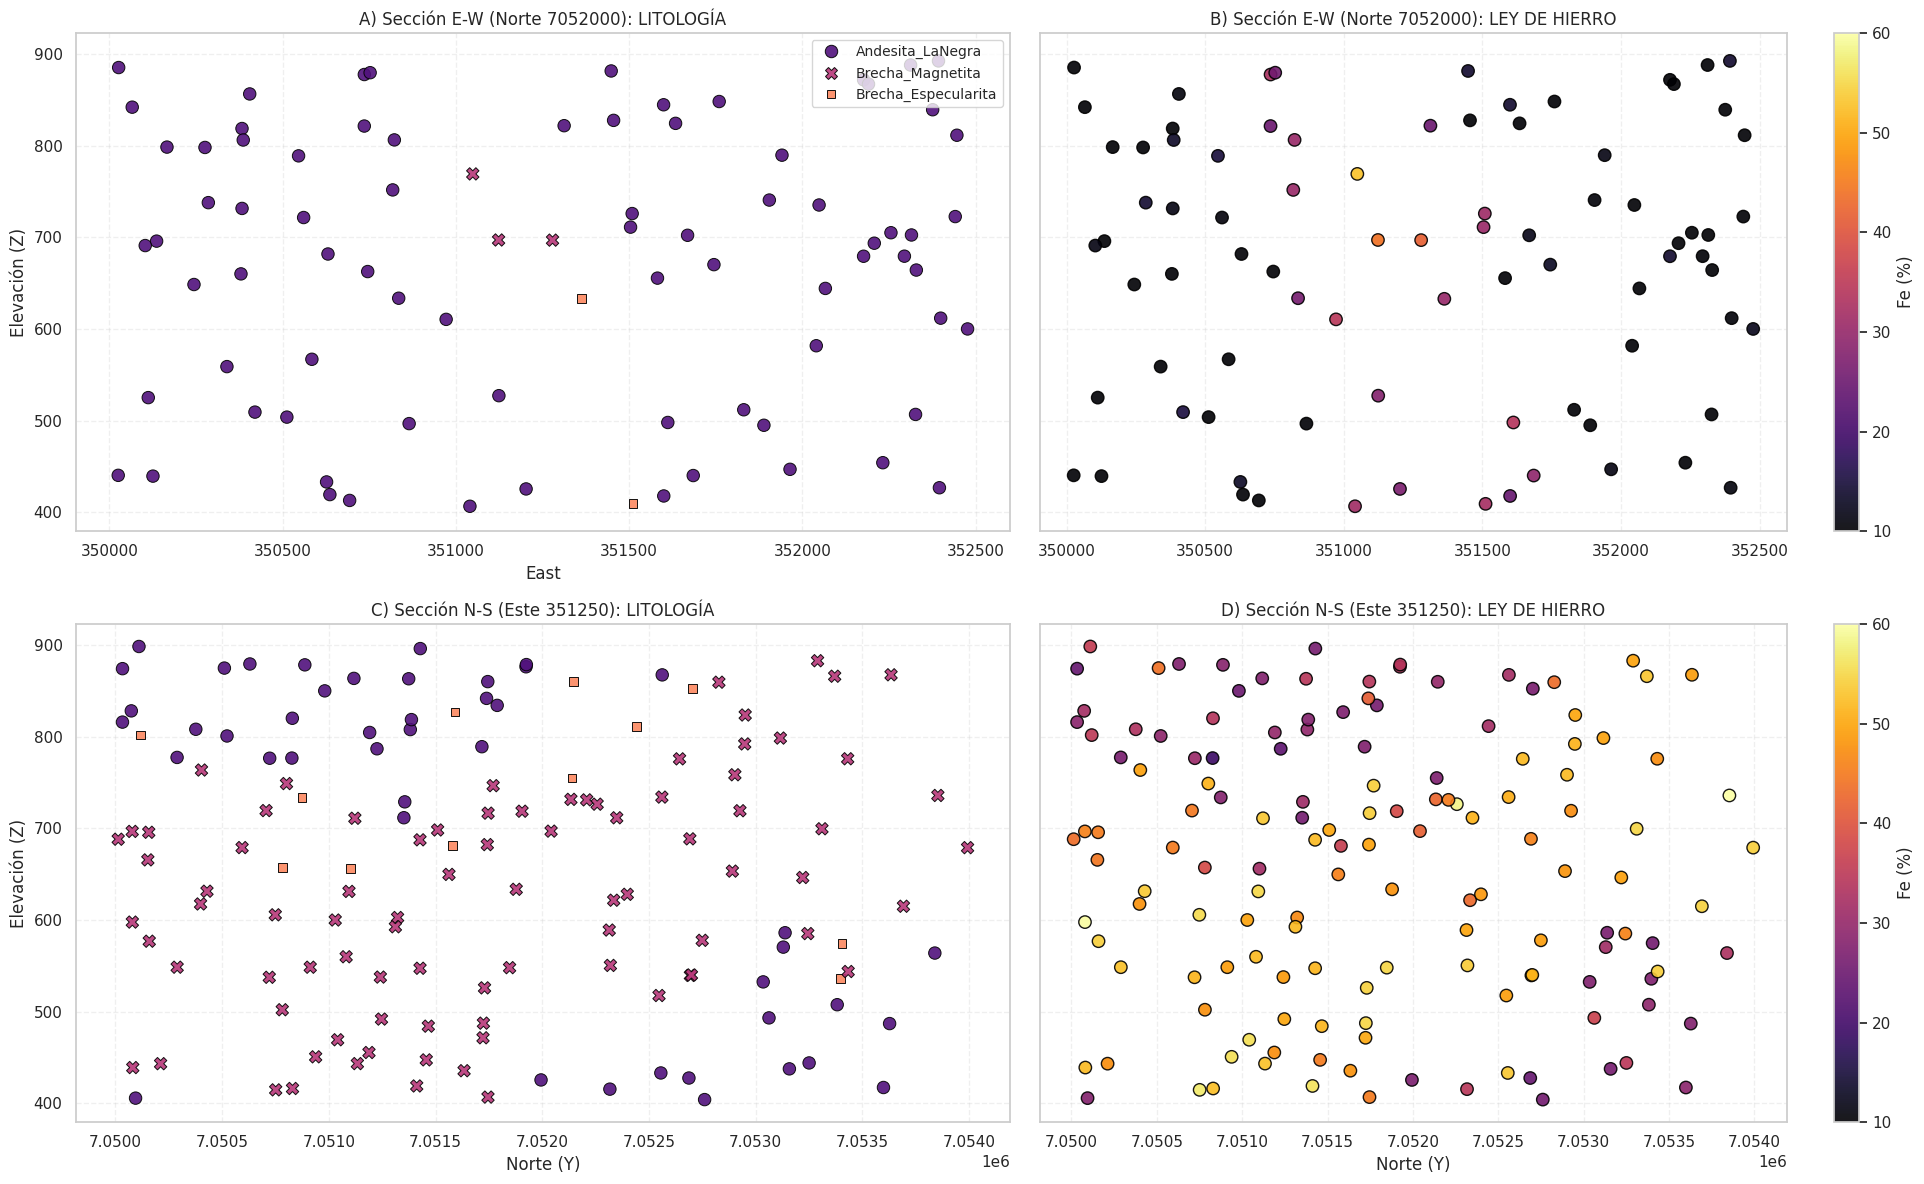

In [6]:
##_4_PANEL DE SECCIONES GEOLÓGICAS (E-W y N-S)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_quad_sections(data, ew_coord=None, ns_coord=None, tolerance=60):
    #
    #Genera un panel de 4 gráficos (2x2) mostrando cortes Transversales y Longitudinales.
    #Fila 1: Sección E-W (Litología y Ley de Hierro)
    #Fila 2: Sección N-S (Litología y Ley de Hierro)
    #

    # Definir Coordenadas de Corte (Centros)
    if ew_coord is None: ew_coord = data['North'].mean() # Corte E-W (fijamos Norte)
    if ns_coord is None: ns_coord = data['East'].mean() # Corte N-S (fijamos Este)

    # Crear los "Slices"
    slice_ew = data[(data['North'] > ew_coord - tolerance) & (data['North'] < ew_coord + tolerance)]
    slice_ns = data[(data['East'] > ns_coord - tolerance) & (data['East'] < ns_coord + tolerance)]

    if slice_ew.empty or slice_ns.empty:
        print("⚠️ No hay suficientes datos para generar los perfiles con esa tolerancia.")
        return

    # Configurar el Panel 2x2
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

    # FILA 1: SECCIÓN ESTE-OESTE (Transversal)
    # Litología E-W
    sns.scatterplot(data=slice_ew, x='East', y='Elev', hue='Litologia', style='Litologia',
                    palette='magma', s=80, edgecolor='black', alpha=0.9, ax=axes[0,0])
    axes[0,0].set_title(f"A) Sección E-W (Norte {ew_coord:.0f}): LITOLOGÍA")
    axes[0,0].set_ylabel('Elevación (Z)')
    axes[0,0].legend(loc='upper right', fontsize='small', frameon=True)
    axes[0,0].grid(True, linestyle='--', alpha=0.3)

    # Ley de Hierro E-W
    sc1 = axes[0,1].scatter(slice_ew['East'], slice_ew['Elev'], c=slice_ew['Fe'],
                            cmap='inferno', s=80, edgecolor='black', alpha=0.9, vmin=10, vmax=60)
    plt.colorbar(sc1, ax=axes[0,1], label='Fe (%)')
    axes[0,1].set_title(f"B) Sección E-W (Norte {ew_coord:.0f}): LEY DE HIERRO")
    axes[0,1].grid(True, linestyle='--', alpha=0.3)

    # FILA 2: SECCIÓN NORTE-SUR (Longitudinal)
    # Litología N-S
    sns.scatterplot(data=slice_ns, x='North', y='Elev', hue='Litologia', style='Litologia',
                    palette='magma', s=80, edgecolor='black', alpha=0.9, ax=axes[1,0], legend=False)
    axes[1,0].set_title(f"C) Sección N-S (Este {ns_coord:.0f}): LITOLOGÍA")
    axes[1,0].set_ylabel('Elevación (Z)')
    axes[1,0].set_xlabel('Norte (Y)')
    axes[1,0].grid(True, linestyle='--', alpha=0.3)

    # Ley de Hierro N-S
    sc2 = axes[1,1].scatter(slice_ns['North'], slice_ns['Elev'], c=slice_ns['Fe'],
                            cmap='inferno', s=80, edgecolor='black', alpha=0.9, vmin=10, vmax=60)
    plt.colorbar(sc2, ax=axes[1,1], label='Fe (%)')
    axes[1,1].set_title(f"D) Sección N-S (Este {ns_coord:.0f}): LEY DE HIERRO")
    axes[1,1].set_xlabel('Norte (Y)')
    axes[1,1].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Generando Panel de Validación Geológica (4 Vistas)...")
# Cortamos por el centro del yacimiento (Falla y Núcleo)
plot_quad_sections(df, ew_coord=7052000, ns_coord=351250, tolerance=60)

In [7]:
##_5_VISUALIZACIÓN 3D DEL MODELO GEOLÓGICO
print("Generando visualización 3D del yacimiento...")
##esto no se vera al exportarlo en github, pero es una visualizacion tipo leapfrog/vulcan, que muestra todo en 3d con sus ubicaciones y valores para cada punto
fig = px.scatter_3d(df.sample(1000), x='East', y='North', z='Elev',
                    color='Litologia',
                    size='Fe',
                    symbol='Zona',
                    opacity=0.7,
                    title='Modelo Geológico 3D: Mantoverde (Fe como tamaño)')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

Generando visualización 3D del yacimiento...


Entrenando Modelo de Predicción de Dureza (BWi)...
   -> R² del Modelo: 0.961
   -> Error Medio Absoluto (MAE): 0.36 kWh/t


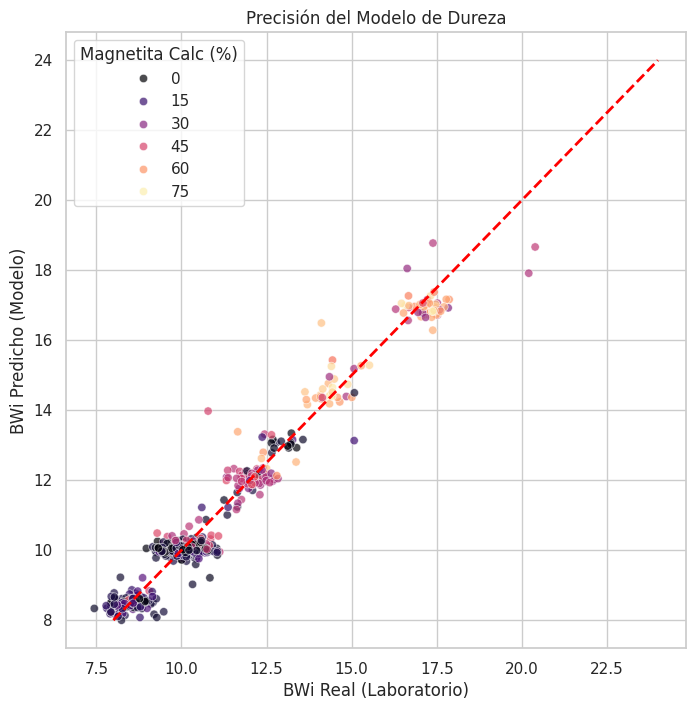

In [8]:
##_6_MODELAMIENTO PREDICCION (XGBOOST)
print("Entrenando Modelo de Predicción de Dureza (BWi)...")

# Preprocesamiento
features = ['East', 'North', 'Elev', 'Fe', 'K', 'S', 'Densidad', 'Silice', 'RQD', 'CaCO3', 'Magnetita_Calc']
target = 'BWi'

# Codificar categóricas
le = LabelEncoder()
df['Litologia_Code'] = le.fit_transform(df['Litologia'])
df['Alteracion_Code'] = le.fit_transform(df['Alteracion'])
features += ['Litologia_Code', 'Alteracion_Code']

X = df[features]
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"   -> R² del Modelo: {r2:.3f}")
print(f"   -> Error Medio Absoluto (MAE): {mae:.2f} kWh/t")

# Gráfico de Predicción vs Real
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, hue=X_test['Magnetita_Calc'], palette='magma', alpha=0.7)
plt.plot([8, 24], [8, 24], 'r--', lw=2)
plt.xlabel('BWi Real (Laboratorio)')
plt.ylabel('BWi Predicho (Modelo)')
plt.title('Precisión del Modelo de Dureza')
plt.legend(title='Magnetita Calc (%)')
plt.show()

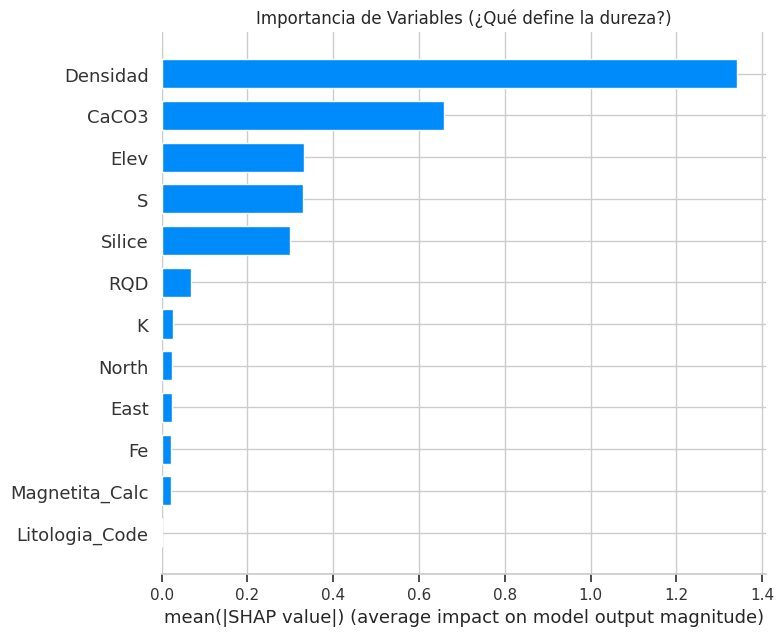

In [9]:
##_7_INTERPRETACIÓN DEL MODELO (SHAP VALUES)###Es importancia de las variables, no lo que la aumenta,
# sino lo que la influencia, puede ser que la baje o suba
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=12, show=False)
plt.title("Importancia de Variables (¿Qué define la dureza?)")
plt.show()

Simulación de Planificación: Optimización de Molienda...


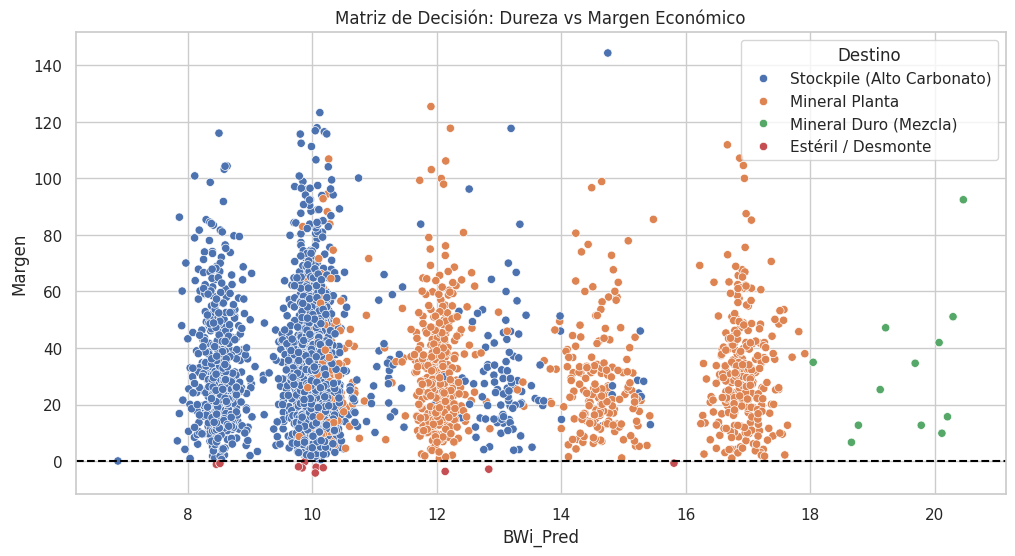

Resumen de Destinos:
Destino
Stockpile (Alto Carbonato)    2040
Mineral Planta                 936
Mineral Duro (Mezcla)           12
Estéril / Desmonte              12
Name: count, dtype: int64


In [10]:
##_8_OPTIMIZACIÓN Y TOMA DE DECISIONES
print("Simulación de Planificación: Optimización de Molienda...")

# Supuestos Económicos
precio_cobre = 3.80 # USD/lb
costo_energia = 0.12 # USD/kWh
recuperacion_base = 0.88

# Predicción para todo el bloque
df['BWi_Pred'] = model.predict(df[features])

# Cálculo de Consumo Energético (kWh/t)
# Formula Bond simplificada: W = 10 * BWi * (1/sqrt(P80) - 1/sqrt(F80))
# Asumimos P80=150um, F80=12000um
p80, f80 = 150, 12000
factor_molienda = 10 * (1/np.sqrt(p80) - 1/np.sqrt(f80))
df['Consumo_Energia'] = df['BWi_Pred'] * factor_molienda

# Costo y Margen
df['Costo_Molienda'] = df['Consumo_Energia'] * costo_energia
df['Valor_Mineral'] = df['CuT'] * 2204.62 * precio_cobre * recuperacion_base / 100 # USD/t
df['Margen'] = df['Valor_Mineral'] - df['Costo_Molienda'] - 15.0 # 15 USD/t costos fijos mina

# Clasificación de Bloques
def clasificar_bloque(row):
    if row['Margen'] < 0: return 'Estéril / Desmonte'
    if row['CaCO3'] > 5.0: return 'Stockpile (Alto Carbonato)'
    if row['BWi_Pred'] > 18: return 'Mineral Duro (Mezcla)'
    return 'Mineral Planta'

df['Destino'] = df.apply(clasificar_bloque, axis=1)

# Visualización de Resultados
plt.figure(figsize=(12, 6))
sns.scatterplot(x='BWi_Pred', y='Margen', hue='Destino', data=df, palette='deep')
plt.axhline(0, color='black', linestyle='--')
plt.title('Matriz de Decisión: Dureza vs Margen Económico')
plt.show()

print("Resumen de Destinos:")
print(df['Destino'].value_counts())

In [11]:
##_9_TABLA DE DECISIÓN_PLANTA
# Objetivo: Generar un entregable final claro para el Jefe de Planta/Mina.
# Filtramos los bloques más críticos (Duros y con alto Carbonato)

import pandas as pd
from IPython.display import display, HTML

print("Generando Reporte de Bloques Críticos para Despacho...")

# Filtrar Bloques de "Alerta" (Duros > 16 BWi o Carbonatos > 4%)
# Solo mostramos una muestra representativa para el reporte
bloques_criticos = df[
    (df['BWi'] > 16.0) |
    (df['CaCO3'] > 4.0)
].sample(15).copy() # Tomamos 15 al azar como ejemplo

# Crear Columnas de Acción
def definir_accion(row):
    acciones = []
    if row['BWi'] > 18.0:
        acciones.append("🔴 REDUCIR TPH (-15%)")
    elif row['BWi'] > 16.0:
        acciones.append("🟡 BLENDING (Mezclar con finos)")

    if row['CaCO3'] > 5.0:
        acciones.append("⛔ EVITAR PILA (Alto Ácido)")
    elif row['CaCO3'] > 3.0:
        acciones.append("⚠️ VIGILAR pH")

    return " + ".join(acciones) if acciones else "🟢 PROCESAR NORMAL"

bloques_criticos['Recomendacion_Planta'] = bloques_criticos.apply(definir_accion, axis=1)

# Seleccionar y Renombrar Columnas para el Reporte
reporte = bloques_criticos[[
    'East', 'North', 'Elev', 'Litologia', 'Fe', 'BWi', 'CaCO3', 'Recomendacion_Planta'
]].round(2)

# Formatear la Tabla (Estilo Semáforo)
def color_bwi(val):
    # Se añade '; color: black' para asegurar contraste legible sobre el fondo de color
    color = '#ff9999' if val > 18 else '#ffe599' if val > 16 else '#99ff99'
    return f'background-color: {color}; color: black'

def color_caco3(val):
    return 'color: red; font-weight: bold' if val > 5 else ''

# Aplicar estilos
styled_table = reporte.style\
    .applymap(color_bwi, subset=['BWi'])\
    .applymap(color_caco3, subset=['CaCO3'])\
    .set_caption("📋 TABLA DE CONTROL DE ALIMENTACIÓN A PLANTA (Turno Mañana)")\
    .format({'East': '{:.0f}', 'North': '{:.0f}', 'Elev': '{:.0f}'})

# Mostrar
display(styled_table)

Generando Reporte de Bloques Críticos para Despacho...


,East,North,Elev,Litologia,Fe,BWi,CaCO3,Recomendacion_Planta
1070,352257,7051263,535,Andesita_LaNegra,11.580000,10.200000,8.570000,⛔ EVITAR PILA (Alto Ácido)
352,352220,7051156,882,Andesita_LaNegra,9.590000,8.840000,9.760000,⛔ EVITAR PILA (Alto Ácido)
888,352023,7052256,462,Andesita_LaNegra,9.830000,10.660000,9.880000,⛔ EVITAR PILA (Alto Ácido)
4,352020,7050248,800,Andesita_LaNegra,15.250000,8.490000,7.990000,⛔ EVITAR PILA (Alto Ácido)
984,352248,7050089,675,Andesita_LaNegra,7.430000,10.640000,6.780000,⛔ EVITAR PILA (Alto Ácido)
449,351221,7051122,711,Brecha_Magnetita,53.370000,17.260000,0.360000,🟡 BLENDING (Mezclar con finos)
584,350038,7052765,730,Andesita_LaNegra,8.260000,10.310000,7.250000,⛔ EVITAR PILA (Alto Ácido)
356,351314,7052782,575,Brecha_Magnetita,51.840000,16.190000,0.000000,🟡 BLENDING (Mezclar con finos)
457,351736,7051658,750,Andesita_LaNegra,10.700000,10.550000,10.460000,⛔ EVITAR PILA (Alto Ácido)
1715,350972,7052049,611,Andesita_LaNegra,34.460000,11.560000,4.780000,⚠️ VIGILAR pH


In [12]:
##_10_EXPORTACIÓN DE DATOS PARA SURPAC/VULCAN/ e.g.
# Objetivo: Guardar el modelo de bloques procesado en un formato compatible (CSV)

print("Exportando Modelo de Bloques para Software Minero...")

# Seleccionar columnas clave para el archivo de intercambio
export_cols = [
    'East', 'North', 'Elev', # Coordenadas
    'Litologia', 'Alteracion', 'Zona', # Geología
    'Fe', 'CuT', 'CaCO3', # Leyes
    'BWi', 'BWi_Pred', # Geometalurgia (Real vs Modelo)
    'Destino' # Variable de Negocio
]

# Crear nombre de archivo con fecha
filename = "Modelo_Bloques_Mantoverde_V2.csv"

# Exportar a CSV
df[export_cols].to_csv(filename, index=False)

print(f"✅ Archivo '{filename}' generado exitosamente.")
print("   -> Listo para importar en Vulcan/Surpac.")
print(f"   -> Total Bloques Exportados: {len(df)}")

# Previsualización de las primeras 5 líneas del archivo
print("\n   --- Vista Previa del Archivo ---")
print(df[export_cols].head(5).to_string(index=False))

Exportando Modelo de Bloques para Software Minero...
✅ Archivo 'Modelo_Bloques_Mantoverde_V2.csv' generado exitosamente.
   -> Listo para importar en Vulcan/Surpac.
   -> Total Bloques Exportados: 3000

   --- Vista Previa del Archivo ---
         East        North       Elev        Litologia      Alteracion     Zona        Fe      CuT     CaCO3       BWi  BWi_Pred                    Destino
351680.696397 7.051525e+06 644.409311 Andesita_LaNegra Clorita_Calcita Sulfuros 10.773969 0.433673 10.859751  9.157829 10.096626 Stockpile (Alto Carbonato)
351220.195998 7.051382e+06 807.969071 Andesita_LaNegra Hematita_Silice   Oxidos 29.353585 0.472318  0.751811 10.799861 10.548594             Mineral Planta
352063.737935 7.051445e+06 626.048069 Andesita_LaNegra Clorita_Calcita Sulfuros  5.118346 0.887997 12.288878 10.066417 10.059157 Stockpile (Alto Carbonato)
350078.615969 7.050788e+06 517.968448 Andesita_LaNegra Clorita_Calcita Sulfuros  3.110782 0.340575  7.259323  9.925716  9.910261 Stockpil

In [13]:
##_11_SIMULACIÓN DE DECISIÓN OPERATIVA (USANDO MODELO PREDICCIÓN)
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("SIMULACIÓN DE TURNO: LLEGADA DE NUEVOS POZOS")

# DATOS DE ENTRADA (Lo que reporta Geología/Laboratorio)
# Necesitamos todas las variables que usa el modelo (XGBoost) para predecir; no siempre pueden estar todas,
# se puede reentrebar con las variables necesarias/disponibles
datos_nuevos = {
    'ID_Pozo':    ['PZ-2024-A', 'PZ-2024-B', 'PZ-2024-C'],
    'East':       [351200,      350800,      351500],
    'North':      [7052000,     7051500,     7053000],
    'Elev':       [850,         600,         500],
    'Litologia':  ['Brecha_Magnetita', 'Andesita_LaNegra', 'Brecha_Magnetita'],
    'Alteracion': ['Magnetita_K', 'Clorita_Calcita', 'Magnetita_K'],
    'Fe':         [45.5,        12.0,        55.0],  # Ley Hierro
    'K':          [3.5,         1.2,         4.0],   # Potasio
    'S':          [0.5,         2.5,         0.2],   # Azufre
    'Densidad':   [4.2,         2.8,         4.6],
    'Silice':     [12.0,        25.0,        8.0],
    'RQD':        [85,          60,          90],
    'CaCO3':      [1.5,         12.0,        1.2],   # Carbonatos
    'CuT':        [0.95,        0.40,        1.10]   # Cobre Total
}

df_decision = pd.DataFrame(datos_nuevos)

# PREPARACIÓN DE DATOS (Ingeniería de Características)
# Debemos aplicar las mismas transformaciones que hicimos al entrenar.

# Calcular Mineralogía (Magnetita) - Misma fórmula Celda 1.5
df_decision['Fe_in_Sulphides'] = df_decision['S'] * 0.87
df_decision['Fe_Oxido'] = (df_decision['Fe'] - df_decision['Fe_in_Sulphides']).clip(lower=0)
df_decision['Magnetita_Calc'] = df_decision['Fe_Oxido'] * 1.38

# Codificar Categorías (Litología/Alteración)
# Nota: Idealmente usaríamos el mismo "le" (encoder) del entrenamiento.
# Aquí hacemos un mapeo manual simple asumiendo el orden alfabético que usa LabelEncoder,
# para asegurar que funcione en esta celda aislada.
map_lito = {'Andesita_LaNegra': 0, 'Brecha_Especularita': 1, 'Brecha_Magnetita': 2}
map_alt  = {'Clorita_Calcita': 0, 'Hematita_Silice': 1, 'Magnetita_K': 2}

df_decision['Litologia_Code'] = df_decision['Litologia'].map(map_lito)
df_decision['Alteracion_Code'] = df_decision['Alteracion'].map(map_alt)

# PREDICCIÓN CON EL MODELO (XGBoost)
# Definir las features en el MISMO orden que el entrenamiento
features_model = [
    'East', 'North', 'Elev', 'Fe', 'K', 'S', 'Densidad', 'Silice',
    'RQD', 'CaCO3', 'Magnetita_Calc', 'Litologia_Code', 'Alteracion_Code'
]

print(" -> Consultando al modelo predictivo de Dureza (BWi)...")
# Aquí usamos el "model"
df_decision['BWi_Predicho'] = model.predict(df_decision[features_model])


# REGLAS DE NEGOCIO Y TOMA DE DECISIÓN
LIMIT_CACO3 = 5.0  # %
LIMIT_BWI   = 16.0 # kWh/t
PRECIO_CU   = 3.8  # USD/lb

def tomar_decision_final(row):
    # Fatalidad: Carbonatos (Consumo Ácido)
    if row['CaCO3'] > LIMIT_CACO3:
        return "🔴 RECHAZO (Alto Ácido)"

    # Economía
    valor_metal = row['CuT'] * 22.04 * PRECIO_CU  # 22.04 lbs/ton métrica
    costo_proces = 15.0

    # Penalización por Dureza Real (Predicha por el modelo)
    if row['BWi_Predicho'] > LIMIT_BWI:
        costo_proces += 4.5 # Sobrecosto de energía

    margen = valor_metal - costo_proces

    # Clasificación
    if margen < 10:
        return "🟡 STOCKPILE (Marginal)"
    elif row['BWi_Predicho'] > LIMIT_BWI:
        return "🟢 PLANTA (Mineral Duro)"
    else:
        return "🟢 PLANTA (Mineral Blando)"

df_decision['Decision_Final'] = df_decision.apply(tomar_decision_final, axis=1)

# VISUALIZACIÓN DEL REPORTE
cols_reporte = ['ID_Pozo', 'Litologia', 'CuT', 'CaCO3', 'BWi_Predicho', 'Decision_Final']

# Formato visual
def estilo_bwi(val):
    color = '#ff9999' if val > LIMIT_BWI else '#99ff99'
    return f'background-color: {color}; color: black'

print("\n--- REPORTE DE DESPACHO (Basado en ML) ---")
display(
    df_decision[cols_reporte].style
    .applymap(estilo_bwi, subset=['BWi_Predicho'])
    .format({'BWi_Predicho': '{:.1f}', 'CuT': '{:.2f}', 'CaCO3': '{:.1f}'})
)

SIMULACIÓN DE TURNO: LLEGADA DE NUEVOS POZOS
 -> Consultando al modelo predictivo de Dureza (BWi)...

--- REPORTE DE DESPACHO (Basado en ML) ---


,ID_Pozo,Litologia,CuT,CaCO3,BWi_Predicho,Decision_Final
0,PZ-2024-A,Brecha_Magnetita,0.95,1.5,17.5,🟢 PLANTA (Mineral Duro)
1,PZ-2024-B,Andesita_LaNegra,0.40,12.0,12.9,🔴 RECHAZO (Alto Ácido)
2,PZ-2024-C,Brecha_Magnetita,1.10,1.2,14.7,🟢 PLANTA (Mineral Blando)
